# Capstone Final Project
## The Battle of the Eateries - Exploring Food Venues in Dubai

The aim of the project is to identify venues in Dubai, UAE based on their rating and average prices. In this notebook, we will identify various venues in Dubai using Foursquare API and Urbanspoon (zomato) API, to help visitors as well as potential investors learn about the current establishments in the city.

Dubai is a booming cosmopolitan city with a very diverse population. Dubai has also become an international travel hub, with many flights that transit through its airport. Given its increasing popularity, the number of hotels and restaurants has significantly increased over the last decade with many new outlets being opened every year. Additionally, Dubai’s growth has meant that construction projects have increasingly sprawled across previously undeveloped areas. Given the hot summers, it is also not surprising that another increase has been experienced in the number of indoor shopping malls, where in addition to stores, food courts, cafes and restaurants abound.

In this project, I will use a dataset based on information collected from two APIs. I will then use various visualization techniques to plot the data and understand any emerging trends, and see whether any insights can be gleaned.  

At a high level, the steps are as follow:
1. I will take a look at Dubai's on the Map using the folium library.

2. I will  fetch the data from two different APIs.

3. I will conduct exploratory data analysis and visualization, followed by some additional analysis that can help us answer specific questions.
Let's get started!

## Import required Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
!conda install -c conda-forge geopy --yes #
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
import xml
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


### Dubai
Dubai is composed of a number of many different areas, especially with the recent expansion and building boom. Dubai's metropolis covers an area of 35 sq km, however recent development has meant that the city has sprawled over a considerably larger area.  

We can use the geopy library to extract the latitude and longitude values of Dubai.

In [2]:
add = 'Dubai, ARE'

geo = Nominatim()
loc = geo.geocode(add)
dxb_lat = loc.latitude
dxb_long = loc.longitude
print('Dubai Geo Coordinates are {}, {}.'.format(dxb_lat, dxb_long))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


Dubai Geo Coordinates are 25.0026994, 55.1674225.


Let's use the folium library to create a complete map zoomed of Dubai. We'll also plot a marker on the coordinates identified above. This would give us a relatively good look at the center point we will be considering for our analysis.

In [3]:
dubai_map = folium.Map(location = [dxb_lat, dxb_long], zoom_start = 12)
folium.Marker([dxb_lat, dxb_long]).add_to(dubai_map)
dubai_map

In [4]:
# save the map as HTML file
dubai_map.save('dubai_map.html')

## Collecting the Data

### Foursquare API

First, I will begin by fetching all venues in Dubai within a range of 10 kms from the coordinates above using the Foursquare API. The Foursquare API has the explore API function which allows us to find venue recommendations within a given radius from the given coordinates. I will use this API to find all the venues needed for my analysis.
I will call the API over and over till we get all venues from the API within the given distance. The maximum venues the API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

Foursquare API requires a client_id, and client_secret to function which can be accessed after creating a developer account.
I will set the radius as 10 Kilometers.
The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In [5]:
# define Foursquare Credentials and Version
FOURSQUARE_CLIENT_ID = 'USWVYONNFO1EFWTPMB10YN4SMCZTY4V2KDVFK2HGC41ZTGRB' # your Foursquare ID
FOURSQUARE_CLIENT_SECRET = 'SL5D0FMECACCFXJYADAD3QMZJ0PIEYCL2OROHYSSGDIJFTF1' # your Foursquare Secret
RADIUS = 10000 # 10 Km
NO_OF_VENUES = 300
VERSION = '20191019' # Foursquare API version

I then define the get_category_type method to get the correct category for each venue.

In [6]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        dxb_lat, 
                                                                        dxb_long, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 10.0 Km
Total 100 venues fetched within a total radius of 10.0 Km
Total 38 venues fetched within a total radius of 10.0 Km

Total 238 venues fetched


A total of 238 venues were found!

### Urbanspoon API


The Urbanspoo (zomato) API allows using its 'search' API to search for any given venue based on certain search filters such as query, latitude, longitude and more. In order to use Zomato, I had to generate a user key which can done by registering for a developer account (similar to Foursquare).

I will use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API in zomato in order get more information regarding each venue.

    The query will be the name of the venue.
    The start defines from what offset we want to start, so it remains at 0.
    The count defines the number of venues I want to fetch. As I have the exact location coordinates (from Foursquare), I will fetch only one.
    I will supply the latitude and longitude values.
   and finally, I  will set the sorting criteria as real_distance so each time we get the venue information we would be searching based on location coordinates.

In [8]:
headers = {'user-key': 'a6e220d078c916f0164e8107c7a27fbb'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

we successfully fetched all the data for the 238 venues!
## Cleaning the Data
Given that I have data from 2 different sources, it is necessary to check whether the data points align. One quick way to do so is to plot each dataset on a separate map and compare them. The figures below are the result of plotting the Foursquare and Urbanspoon data on separate maps using Folium. I did this to see whether the locations overlapped as I had expected them to.
### Foursquare Map


In [9]:
dubai_map = folium.Map(location = [dxb_lat, dxb_long], zoom_start = 12)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'light blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(dubai_map)  


# save the map as HTML file
dubai_map.save('dubai_map_foursquare.html')
dubai_map

### Urbanspoon Map
As I was attempting to map the Urbanspoon data, I kept encountering a type error. As such, I wanted to explore the column data types to uncover the reason.

In [10]:
print (zomato_venues.dtypes)

venue             object
latitude          object
longitude         object
price_for_two    float64
price_range      float64
rating            object
address           object
dtype: object


As can be noted, the issue is related to the longitude and latitude variables being strings. To fix this problem, I convert the offending columns into numerical form.

In [11]:
zomato_venues['longitude'] = zomato_venues['longitude'].astype(float)
zomato_venues['latitude'] = zomato_venues['latitude'].astype(float)

and a quick check to make sure that the data is in the required format.

In [12]:
print (zomato_venues.dtypes)

venue             object
latitude         float64
longitude        float64
price_for_two    float64
price_range      float64
rating            object
address           object
dtype: object


Great! Now the Urbanspoon map!

In [13]:
dubai_map = folium.Map(location = [dxb_lat, dxb_long], zoom_start = 12)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(dubai_map)  
# save the map as HTML file
dubai_map.save('dubai_map_zomato.html')
dubai_map

We can already see that similar patterns appear - many venues identified by both Foursquare and Urbanspoon.For example, both maps show a clustering around the Dubai Marina area - which makes sense given that it is on the waterfront and boasts a large number of hotels, outlets and restaurants. There are however some datapoints that do not align. To explore why, I will combine the 2 datasets and explore further. To combine the two datasets, I need to check that the latitude and longitude values of each corresponding venue match. I will round both the latitude and longitude values upto 4 decimal places. Next, I will calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [14]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [15]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

Now let's take a closer look at the dataset

In [16]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Al Furjan Pavilion,Shopping Mall,25.0246,55.1529,Al Arrab,25.0246,55.1528,205.0,3.0,2.7,"Ground Floor, Al Furjan Pavilion, Al Furjan, D...",0.0000,-0.0001
1,Me'aisem City Center (معيصم سيتي سنتر),Shopping Mall,25.0398,55.1979,Starbucks,25.0397,55.1980,70.0,2.0,3.7,"Ground Level, City Centre Me'aisem , Al Fay Ro...",-0.0001,0.0001
2,Jumeirah Islands Club,Beach Bar,25.0525,55.1627,The Glasshouse,25.0523,55.1627,320.0,4.0,3.4,"Jumeirah Islands Clubhouse, Emirates Hills, Dubai",-0.0002,0.0000
3,"Aloft Me'aisam, Dubai",Hotel,25.0379,55.1972,City Limits,25.0379,55.1972,235.0,3.0,3.6,"Ground Level, Aloft Me'aisam, Dubai Production...",0.0000,0.0000
4,Pinkberry,Frozen Yogurt Shop,25.0539,55.1710,Pinkberry,25.0540,55.1709,90.0,2.0,3.9,"Ground Floor, Town Center, Emirates Hills, Dubai",0.0001,-0.0001
5,Baskin Robbins,Ice Cream Shop,25.0423,55.1185,Baskin Robbins - Ibn Battuta Mall,25.0421,55.1186,45.0,1.0,3.7,"Tunisia Food Court, Ibn Battuta Mall, Garden C...",-0.0002,0.0001
6,Ghaya Grand Hotel l غايا جراند,Hotel,25.0340,55.2036,Lobby Lounge - Ghaya Grand Hotel,25.0341,55.2035,150.0,3.0,3.1,"Lobby Level, Ghaya Grand Hotel, IMPZ, Dubai",0.0001,-0.0001
7,Paul Café,French Restaurant,25.0398,55.1980,PAUL Bakery & Restaurant,25.0398,55.1981,210.0,3.0,3.9,"Ground Level, City Centre Me'aisem, Al Fay Roa...",0.0000,0.0001
8,The Hamptons Cafe,Restaurant,25.0646,55.1479,The Hamptons Cafe,25.0645,55.1478,240.0,3.0,4.3,"Street 1, Jumeirah Islands, Emirates Hills, Dubai",-0.0001,-0.0001
9,Starbucks,Coffee Shop,25.0539,55.1711,Starbucks,25.0539,55.1711,70.0,2.0,3.6,"Ground Floor, Town Center, Emirates Hills, Dubai",0.0000,0.0000


Looks much better, and I now have 130 remaining venues.
I selected the venue name from Urbanspoon and also calculated the average price per person by dividing the column price_for_two by 2 and dropping this column from the dataset along with other columns I don't need for my project.

In [17]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

This is now my final dataset:

In [18]:
selected_venues

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Shopping Mall,Al Arrab,25.0246,55.1528,3.0,2.7,"Ground Floor, Al Furjan Pavilion, Al Furjan, D...",102.5
1,Shopping Mall,Starbucks,25.0397,55.1980,2.0,3.7,"Ground Level, City Centre Me'aisem , Al Fay Ro...",35.0
2,Beach Bar,The Glasshouse,25.0523,55.1627,4.0,3.4,"Jumeirah Islands Clubhouse, Emirates Hills, Dubai",160.0
3,Hotel,City Limits,25.0379,55.1972,3.0,3.6,"Ground Level, Aloft Me'aisam, Dubai Production...",117.5
4,Frozen Yogurt Shop,Pinkberry,25.0540,55.1709,2.0,3.9,"Ground Floor, Town Center, Emirates Hills, Dubai",45.0
5,Ice Cream Shop,Baskin Robbins - Ibn Battuta Mall,25.0421,55.1186,1.0,3.7,"Tunisia Food Court, Ibn Battuta Mall, Garden C...",22.5
6,Hotel,Lobby Lounge - Ghaya Grand Hotel,25.0341,55.2035,3.0,3.1,"Lobby Level, Ghaya Grand Hotel, IMPZ, Dubai",75.0
7,French Restaurant,PAUL Bakery & Restaurant,25.0398,55.1981,3.0,3.9,"Ground Level, City Centre Me'aisem, Al Fay Roa...",105.0
8,Restaurant,The Hamptons Cafe,25.0645,55.1478,3.0,4.3,"Street 1, Jumeirah Islands, Emirates Hills, Dubai",120.0
9,Coffee Shop,Starbucks,25.0539,55.1711,2.0,3.6,"Ground Floor, Town Center, Emirates Hills, Dubai",35.0


It appears that Rogue Cafe has a rating of 0. I decided that I should drop the venues which have 0.0 rating since it indicates that the venues has not been rated yet (should running this notebook in the future return different results).

In [19]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 128


# Methodology

I want to identify venues in Dubai based on their rating and average price. This would enable visitors to Dubai to select venues they would be interested in visiting based on their preferences. 

As a first step, I retrieved the data from two APIs (Foursquare and Urbanspoon). I extracted the venue information from the center of Dubai, upt o a radius of 10 km. The latitude and longitude values were then used to fetch venue rating and price from Urbanspoon.

Next, I then explored the data retrieved from the two APIs on two separate maps. The data from the two sources was then merged based on the name, latitude and longitude values from the two datasets. The final dataset now only included the rating and average price per person for each venue.

To continue the analysis, I will look at the dataset I created and produce some visualizations based on the ratings and price of each venue. This will help identify places where there may be clusters of venues that may be of interest. I will also explore venues with high ratings and those with low ratings (as well as prices) to determine whether any observations or inferences can be made. Finally, I will use clustering to identify whether venues with certain characteristics could be identified, and what those characteristics may be. 

# Analysis

The merged dataset is now ready.

I will inspect venues based on their rating. The rating of a venue is based on user reviews and ranges from 1 to 5. I will also analyze the venues based on their price per person as well as the price range.

## Categories

I have various types of venues in the final dataset. I will first take a look at the venues and explore the most popular venue categories. This can show two different things, popularity as well as whether there are any growth opportunities (for those venue categories with low counts).

<BarContainer object of 45 artists>

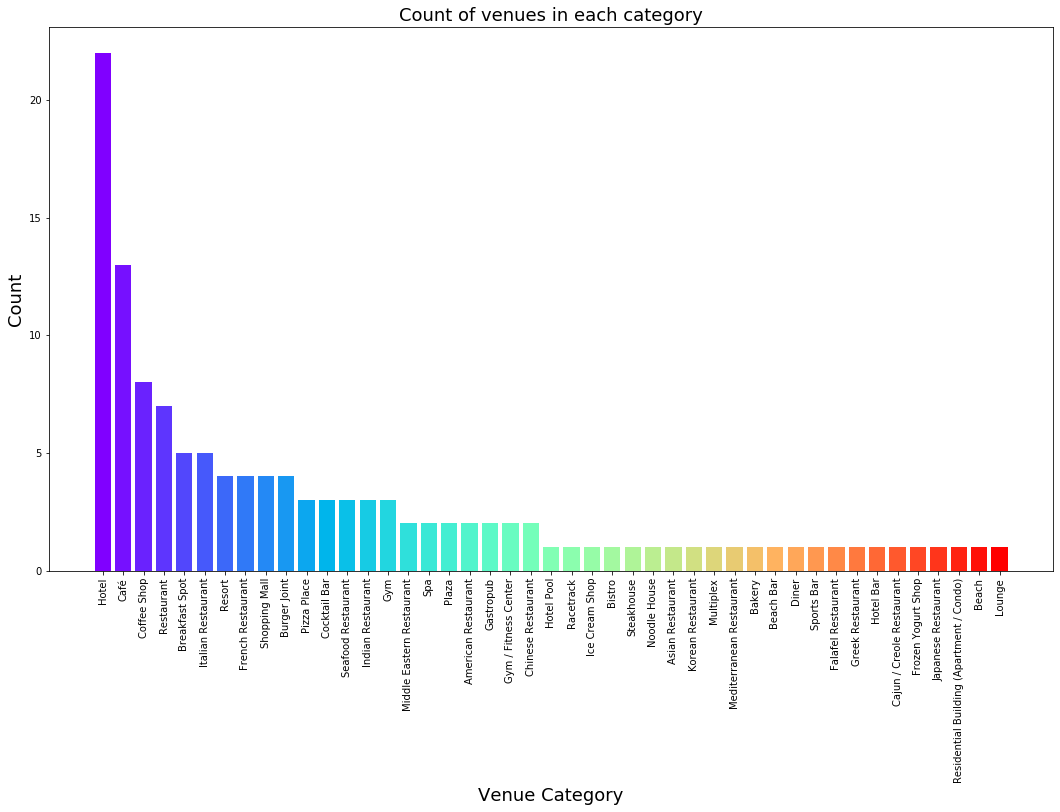

In [20]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (18, 10))
plt.xticks(rotation = 90)
plt.xlabel("Venue Category", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
plt.title("Count of venues in each category", fontsize = 18)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

The figure reveals that hotels, cafes/coffee shops and restaurants are the most prevalent venues in the area I have explored. On the far end of the spectrum, it appears that lounges, frozen yogurt shops and some types of restaurants aren’t as prevalent. This may be a function of several things, there are categories (subtypes of restaurants) that are listed outside the overall “restaurant” category. This means that a more nuanced analysis of the dataset may be necessary. Given the aims of this project and its scope, I will not be merging additional categories, however, it is a limitation that needs to be noted. The fact that hotels are the most popular venue is not surprising given Dubai’s growth and popularity as a travel destination, as well as the waterfront cluster we observed on the map.

## Ratings

The rating of a venue is an important factor that can influence a visitors decision as to whether they should visit a certain venue or not. It also gives an idea for investors as to what the competition looks like in certain categories of venues, which could impact whether they want to enter the market or not. 
To further explore ratings, I will first examine the average rating for all the venues in the area of the city I am exploring. Next, I will plot the venues on the map and color code them to represent their rating.

The first step is to identify rating values and plot them as a bar plot with their counts to see the most common rating.

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Count of venues with given rating')

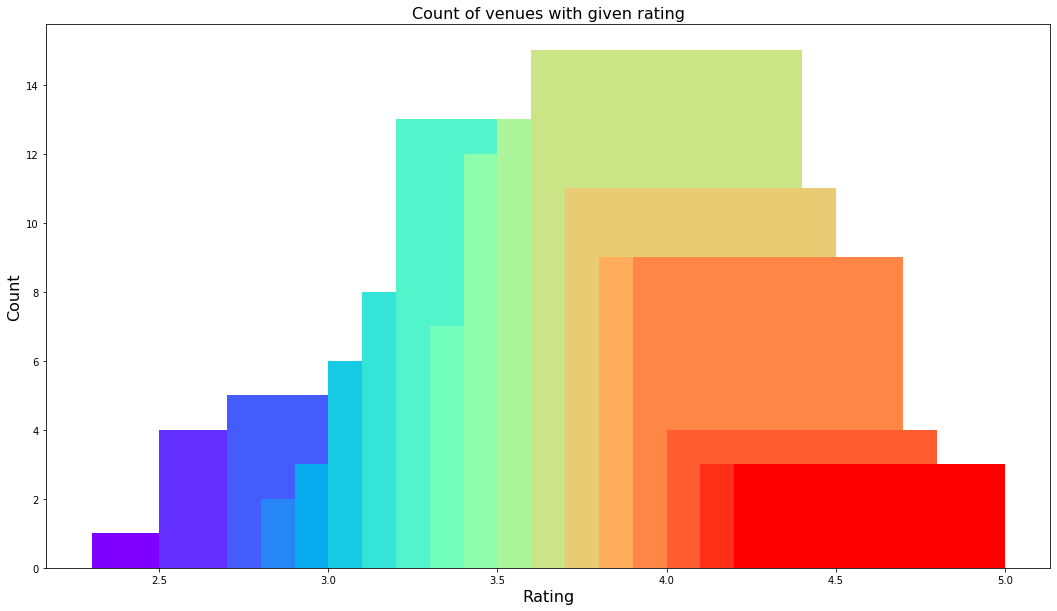

In [21]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (18, 10))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

While the above figure is pretty, it is difficult to examine the questions of interest from it. One thing that can be noted is that many venues have ratings hovering around 4.

A better way to visualize ratings is by creating "bins" for ranges of ratings and then plot them. The ratings will be divided between 4 bins:

    1 to 2
    2 to 3
    3 to 4
    4 to 5

In [22]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'blue'}

dubai_map = folium.Map(location = [dxb_lat, dxb_long], zoom_start = 12)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(dubai_map)  

dubai_map.save("Venues Ratings.html")
dubai_map

Blue corresponds to a “very good” rating, while green corresponds to “good”. It appears that most venues have a rating of either “good” or “very good”.
I will now explore venues based on their prices. In the dataset, I have two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Urbanspoon.

I will first explore the average_price using a scatter plot between of price and the count of venues with that average price. The scatterplot points are sized based on the price for additional clarity.

Text(0.5, 1.0, 'Count of venues with given average price')

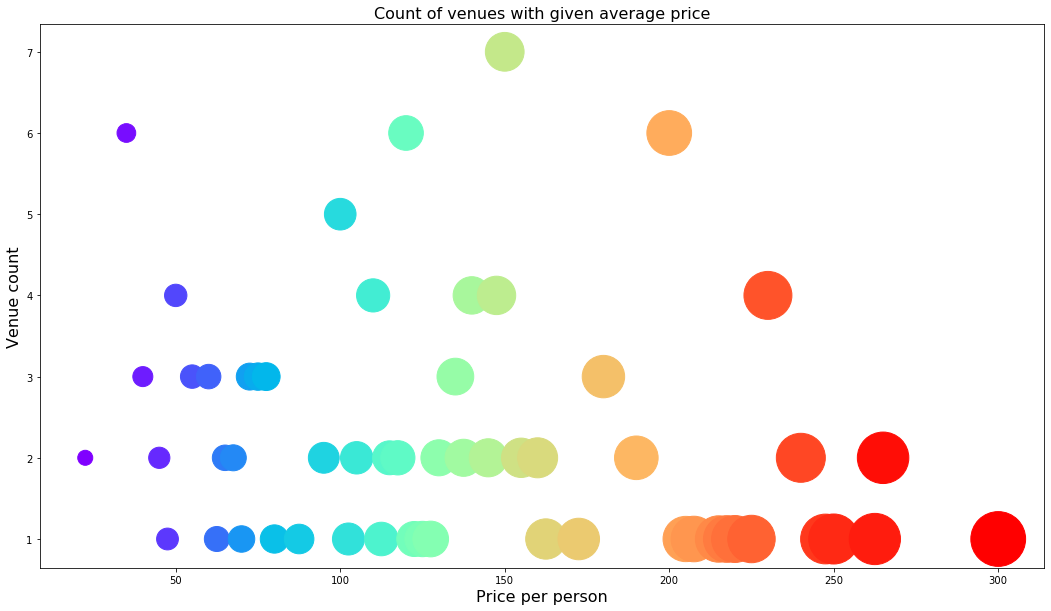

In [24]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (18, 10))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

It appears that large number of venues have an average price between 100 to 250 AEDs.

Visitors and travelers are usually looking to go to venues that fit within their budgets. I will therefore use the price_range column to plot the venues on a map. Venues with lower prices are shown in green and we move towards red as the price increases.

In [25]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

dubai_map = folium.Map(location = [dxb_lat, dxb_long], zoom_start = 12)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(dubai_map)  

dubai_map.save("Venues Prices.html")
dubai_map

it appears that there are few lower priced venues near the waterfront/Dubai Marina; which given Dubai’s emphasis on luxury as well as the location I have explored is somewhat expected.

## Clustering

I will now cluster all  venues based on their price range, location. This is so I can identify similar venues and any relationships between them. For simplicity/clarity, I will cluster the venues into two separate groups.

In [26]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Shopping Mall,Al Arrab,25.0246,55.1528,3.0,2.7,"Ground Floor, Al Furjan Pavilion, Al Furjan, D...",102.5,Okay
1,1,Shopping Mall,Starbucks,25.0397,55.1980,2.0,3.7,"Ground Level, City Centre Me'aisem , Al Fay Ro...",35.0,Good
2,0,Beach Bar,The Glasshouse,25.0523,55.1627,4.0,3.4,"Jumeirah Islands Clubhouse, Emirates Hills, Dubai",160.0,Good
3,1,Hotel,City Limits,25.0379,55.1972,3.0,3.6,"Ground Level, Aloft Me'aisam, Dubai Production...",117.5,Good
4,1,Frozen Yogurt Shop,Pinkberry,25.0540,55.1709,2.0,3.9,"Ground Floor, Town Center, Emirates Hills, Dubai",45.0,Good


In [27]:
dubai_map = folium.Map(location = [dxb_lat, dxb_long], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(dubai_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(dubai_map)

dubai_map.save("Venues Clusters.html")
dubai_map

From the map, it is difficult to tell what the features are for each cluster. But it appears as if there is an even geographical spread. To explore this some more, I will examine each cluster separately.

In [28]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Beach Bar,The Glasshouse,25.0523,55.1627,4.0,3.4,"Jumeirah Islands Clubhouse, Emirates Hills, Dubai",160.0,Good
1,0,Hotel,Revo Cafe - Mövenpick Hotel Ibn Battuta Gate D...,25.0418,55.1156,3.0,3.4,"Mövenpick Hotel Ibn Battuta Gate Dubai, Next t...",140.0,Good
2,0,French Restaurant,Couqley French Bistro & Bar,25.0656,55.1384,4.0,4.5,"Laguna Tower, Mövenpick Hotel, Cluster A, Jume...",207.5,Very good
3,0,Pizza Place,Jazz@PizzaExpress,25.0663,55.1380,3.0,4.6,"Basement Level, Mövenpick Hotel, Cluster A, Ju...",137.5,Very good
4,0,Hotel,Urban Bar & Kitchen - Mövenpick Hotel Jumeirah...,25.0660,55.1381,4.0,3.9,"Level B1, Mövenpick Hotel Jumeirah Lakes Tower...",150.0,Good
5,0,Greek Restaurant,Mythos,25.0750,55.1457,4.0,4.4,"Basement Level, Armada BlueBay Hotel, Cluster ...",160.0,Very good
6,0,Hotel,Bistro Des Arts,25.0769,55.1406,4.0,3.9,"Supermarket Level, Dubai Marina Mall, Marina P...",230.0,Good
7,0,Restaurant,Cargo,25.0761,55.1388,4.0,3.9,"3rd Floor, Pier 7, Behind Dubai Marina Mall, A...",172.5,Good
8,0,Hotel,Quench - Sofitel Dubai Jumeirah Beach,25.0751,55.1320,4.0,3.1,"Sofitel Dubai Jumeirah Beach, The Walk, Jumeir...",150.0,Good
9,0,Hotel,The Daily - Rove Dubai Marina,25.0696,55.1279,3.0,3.8,"Al Seba Street, Dubai Marina, Dubai",145.0,Good


In [29]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 3.74 and rating spread around 3.82


In [30]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Shopping Mall,Al Arrab,25.0246,55.1528,3.0,2.7,"Ground Floor, Al Furjan Pavilion, Al Furjan, D...",102.5,Okay
1,1,Shopping Mall,Starbucks,25.0397,55.1980,2.0,3.7,"Ground Level, City Centre Me'aisem , Al Fay Ro...",35.0,Good
2,1,Hotel,City Limits,25.0379,55.1972,3.0,3.6,"Ground Level, Aloft Me'aisam, Dubai Production...",117.5,Good
3,1,Frozen Yogurt Shop,Pinkberry,25.0540,55.1709,2.0,3.9,"Ground Floor, Town Center, Emirates Hills, Dubai",45.0,Good
4,1,Ice Cream Shop,Baskin Robbins - Ibn Battuta Mall,25.0421,55.1186,1.0,3.7,"Tunisia Food Court, Ibn Battuta Mall, Garden C...",22.5,Good
5,1,Hotel,Lobby Lounge - Ghaya Grand Hotel,25.0341,55.2035,3.0,3.1,"Lobby Level, Ghaya Grand Hotel, IMPZ, Dubai",75.0,Good
6,1,French Restaurant,PAUL Bakery & Restaurant,25.0398,55.1981,3.0,3.9,"Ground Level, City Centre Me'aisem, Al Fay Roa...",105.0,Good
7,1,Restaurant,The Hamptons Cafe,25.0645,55.1478,3.0,4.3,"Street 1, Jumeirah Islands, Emirates Hills, Dubai",120.0,Very good
8,1,Coffee Shop,Starbucks,25.0539,55.1711,2.0,3.6,"Ground Floor, Town Center, Emirates Hills, Dubai",35.0,Good
9,1,Hotel,Costa Coffee,25.0465,55.1191,3.0,3.2,"Premier Inn, Ibn Batuta Mall, Jebel Ali Villag...",50.0,Good


In [31]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 2.77 and rating spread around 3.84


It appears that Cluster 0 includes more higher end restaurants than Cluster 1 did. Both clusters appear to be close in terms of ratings. A closer inspection of the types of venues shows that cluster 0 includes venues located in hotels while cluster 1 has more venues located in shopping malls, which could also justify the price difference.

# Results and Discussion

Based on our analysis above, there are some conclusions that can be made that could be be useful to visitors to Dubai as well as to someone exploring the idea of opening up a venue. 

After collecting data from the Foursquare and Urbanspoon APIs (for a radius of 10 km around the coordinates I was exploring), I got a list of 238 different venues. However, not all venues from the two APIs were identical. By inspecting their coordinates more closely I was able to combine the two datasets and remove the outliers. This resulted in a total venue count of 128 venues which is not bad for an area of 10 sq kms.

I was able to identify that the majority of venues were hotels, coffee shops  and restaurants; whereas lounges were not as common in that area. This type of information could assist visitors who wish to discover Dubai in figuring out where they would like to stay (hotel) or eat based on different variables which I explored next. 

While the complete range of ratings range from 1 to 5, the majority venues have ratings close to 4. This means that on average, this area of Dubai has venues that are considered to be of high quality or viewed favourably. By plotting the ratings on Dubai's map, I also noted that the highly rated venues were closest to the waterfront (Dubai Marina) which is a very popular area. 

By looking at prices for each venue, we found a wide-range of prices, suggesting that the particular area I was exploring in Dubai could cater to visitors with different budgets. By plotting the prices on the map, it also appeared that the most expensive venues were near the waterfront (Dubai Marina).

Finally, through clusters I was able to cluster the data into two groups, with price and type of venue being the dominant features. The two clusters had similar ratings, but diverged in price range. It also appeared that the lower priced venues were located in shopping malls, whereas the cluster of higher priced venues were located mostly in hotels. 

A business-oriented individual who is seeking to explore opportunities in Dubai could use the insights dervied from this analysis to learn about possible opportunities (not many lounges appeared as venues) and can also understand that location will highly impact how popular a venue is. Dubai Marina is a very popular area, but it also includes venues that appeared to be mostly in hotels and that were highly priced. Setting up a business in a shopping mall does not mean that the venue will be less popular (since ratings appeared to be similar in both clusters), but the average price appeared to be more reasonable.  

# Conclusion

The purpose of this project was to explore an area of Dubai that visitors to the city could possibly want to visit. The venues were identified using two different data sources, Foursquare and Urbanspoon. Each dataset provided important information, and by combining the datasets, I was able to examine these venues based on their location and draw some insights regarding their ratings, price ranges among others. It appears that Dubai Marina is a highly popular area in Dubai that visitors will have a wide range of options in terms of venues to visit. Staying in a hotel in Dubai Marina would give visitors ample options in terms of dining and recreation.